In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
from time import time
from xml.etree import ElementTree as ET
import os
import pandas as pd
import sys
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from scipy.ndimage import zoom
import smtplib
from email.mime.text import MIMEText
import re
import skimage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import h5py

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

%matplotlib inline

import BigBadBrain as bbb

In [2]:
def pd_csv_to_h5py(folder, file):
    print('loading raw photodiode data... ',end='')
    #load raw data from csv
    load_file = os.path.join(folder, file)
    temp = np.genfromtxt(load_file, delimiter=',',skip_header=1)
    t = temp[:,0]
    pd1 = temp[:,1]
    pd2 = temp[:,2]
    print('done')

    #save as h5py file
    print('saving photodiode data as h5py file...',end='')
    save_file = os.path.join(folder, 'photodiode.h5')
    with h5py.File(save_file, 'w') as hf:
        hf.create_dataset('time',  data=t)
        hf.create_dataset('pd1',  data=pd1)
        hf.create_dataset('pd2',  data=pd2)
    print('done')

def load_h5py_pd_data(folder):
    print('loading photodiode data... ',end='')
    #load from h5py file
    load_file = os.path.join(folder, 'photodiode.h5')
    with h5py.File(load_file, 'r') as hf:
        t = hf['time'][:]
        pd1 = hf['pd1'][:]
        pd2 = hf['pd2'][:]
    print('done')
    return t, pd1, pd2

In [3]:
vision_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_28/visual'

In [4]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'

In [341]:
durs = np.genfromtxt(os.path.join(vision_path, 'dur.txt'))

In [5]:
### Load photodiode data ###

# Try to load from h5py file
try:
    t, pd1, pd2 = load_h5py_pd_data(vision_path)
    
# First convert from csv to h5py, then load h5py
except:
    pd_csv_to_h5py(vision_path,'photodiode.csv')
    t, pd1, pd2 = load_h5py_pd_data(vision_path)

loading photodiode data... loading raw photodiode data... done
saving photodiode data as h5py file...done
loading photodiode data... done


In [6]:
t[-1]

1799999.9

In [ ]:
### PD starts at 0 at last time is 1800000
### fictrac should be on the same exact time, correct?
### ie, the first frame trigger should be at 0, and the last trigger should be at 1800000 - 20
### might be good to record fictrac triggers as well for debugging

In [7]:
### Load visual stim data ###

stimuli = np.load(os.path.join(vision_path, 'stimuli_master.npy'))

# remove grey_stimuli
stimuli = [stim[0] for i,stim in enumerate(stimuli) if stimuli[i,0]['name'] != 'Grey']

In [8]:
### Load meta data ###

#need to update github code to save metadata as dict
stimuli_meta = {'num_blocks': 4,
                'inter_block_dur': 180,
                'post_stim_dur': 2000,
                'num_cycles': 18,
                'block_dur': 225}

In [9]:
def get_pd_thresh(pd):
    _, bins, _ = plt.hist(pd,bins=5)
    plt.close()
    threshold = (bins[0] + bins[-1]) / 2
    return threshold

In [101]:
def parse_photodiode(pd, stimuli):
    # Get threshold for on/off
    threshold = get_pd_thresh(pd)

    # Find timepoints when the light is off (and convert to ms)
    pd_sampling_to_ms_conversion = 10
    pd_off = np.where(pd<threshold)[0]/pd_sampling_to_ms_conversion

    # Find timepoints of rising edges
    min_gap = 1 # Lets give a 1 ms window for defining edges
    pd_on_edges = pd_off[np.where(np.diff(pd_off)>min_gap)[0]]

    # Remove any very early on edges cause by projector still getting ready etc.
    remove_on_before = 60*1000 # Currently a 1 min minimum
    pd_on_edges = [x for x in pd_on_edges if x > remove_on_before]
    
    # Add on edge at 0
    pd_on_edges = np.insert(pd_on_edges,0,0)

    # Find on_edges that correspond to stimuli presentation
    min_gap = 100 # Edges greater than 100ms apart are counted as stimuli starts
    stimuli_starts = pd_on_edges[np.where(np.diff(pd_on_edges)>min_gap)[0]+1]

    #if stimuli_starts[0] < 1000*60:
        
    
    # Make sure we have successfully found all stimuli
    if len(stimuli_starts) == len(stimuli):
        print('Successfully parsed all stimuli from photodiode output.')
    else:
        print(len(stimuli_starts))
        print(len(stimuli))
        raise Exception('Failed to successfully parse stimuli from photodiode output')
    return stimuli_starts #in ms

In [102]:
stimuli_starts = parse_photodiode(pd1,stimuli)

### Get unique stimuli
unique_stimuli = [dict(y) for y in set(tuple(x.items()) for x in stimuli)]

### Add times list to each unique stimulus
for unique_stimulus in unique_stimuli:
    unique_stimulus['times'] = [stimuli_starts[i] for i, x in enumerate(stimuli) if x == unique_stimulus]

Successfully parsed all stimuli from photodiode output.


In [20]:
### Lets try pulling from fictrac at these times

fictrac = load_fictrac(root_path, 'fly_28')


~~ Loading Fictrac ~~
Duration: 4.04 sec


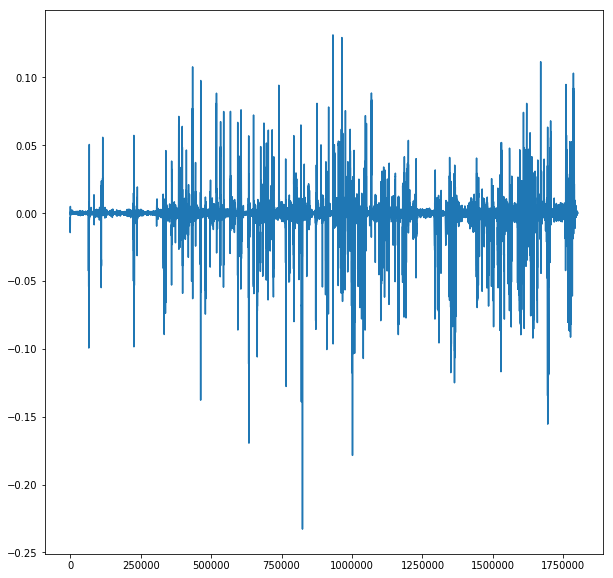

In [76]:
plt.figure(figsize=(10,10))
plt.plot(raw_fictrac_times,fictrac_smoothed)

(1400000, 1700000)

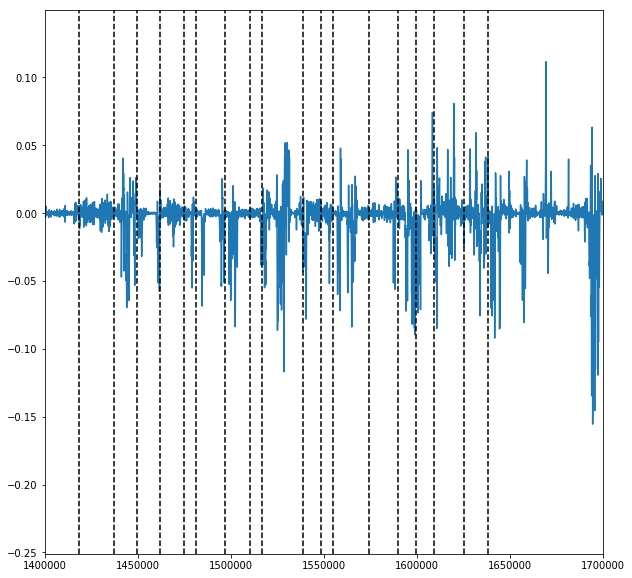

In [77]:
plt.figure(figsize=(10,10))
plt.plot(raw_fictrac_times,fictrac_smoothed)
for i in unique_stimuli[0]['times']:
    plt.axvline(i,color='k',linestyle='--')
plt.xlim(1400000,1700000)

In [4]:
unique_stimuli = bbb.get_stimuli(folder)
fictrac = bbb.load_fictrac()

loading photodiode data... done
loading visual stimuli data... done
Successfully parsed all stimuli from photodiode output.

~~ load_fictrac ~~
load_fictrac done. Duration: 3.22 sec


In [6]:
fictrac_interp_temp = np.asarray(fictrac['speed'])

In [17]:
unique_stimuli[1]

{'angle': 0,
 'color': 1,
 'name': 'SineGrating',
 'period': 40,
 'rate': 100,
 'times': [143186.5,
  145011.7,
  148627.3,
  153694.3,
  155467.4,
  158865.6,
  163793.6,
  165514.5,
  168738.9,
  172058.9,
  175118.2,
  178221.1,
  181575.9,
  186460.4,
  188137.8,
  191527.3,
  195134.2,
  198271.9,
  201600.5,
  204885.8,
  209987.7,
  211595.6,
  216584.3,
  218261.7,
  223459.0,
  225101.8,
  230029.6,
  233367.1,
  235035.9,
  238468.9,
  241528.3,
  246543.0,
  248151.0,
  251445.0,
  256564.1,
  259719.0,
  263099.9,
  266176.6,
  269635.7,
  271330.5,
  276293.2,
  279830.7,
  281595.0,
  285088.8,
  289964.7,
  291529.0,
  296778.5,
  298308.3,
  301480.5,
  306113.0,
  309528.7,
  312866.1,
  314439.2,
  318080.8,
  323391.3,
  324929.6,
  328553.8,
  331786.9,
  336497.7,
  339756.9,
  343050.8,
  346657.8,
  350169.0,
  353184.9,
  356435.4,
  358208.5,
  363188.5,
  366473.8,
  369767.7,
  371558.2,
  374939.1,
  380101.7,
  383430.5,
  384968.9,
  389670.8,
  573013.0,


In [2]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_29/central'
unique_stimuli = bbb.get_stimuli(folder)
fictrac = bbb.load_fictrac(folder)

loading photodiode data... done
loading visual stimuli data... done
Successfully parsed all stimuli from photodiode output.

~~ load_fictrac ~~
load_fictrac done. Duration: 3.12 sec


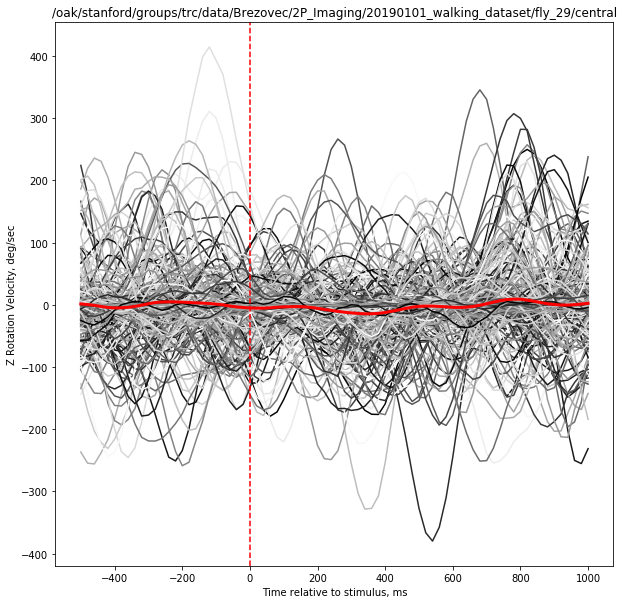

In [4]:
bbb.create_stim_triggered_behavior_plot(fictrac, unique_stimuli[0], folder)

In [7]:
x=True
y=False
if x and y:
    print('hi')

In [125]:
fps = 50
dur = 30 * 60 * 1000
behavior = 'dRotLabZ'

camera_rate = 1/fps * 1000 # camera frame rate in ms
raw_fictrac_times = np.arange(0,dur,camera_rate)

sphere_radius = 4.5e-3
fictrac_vector = np.rad2deg(np.asarray(fictrac[behavior])) # now in deg per 20ms
fictrac_vector = fictrac_vector * 50 # now in deg per sec

# Smooth
fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(fictrac_vector,sigma=3,truncate=1)

# Interpolate
# Warning: interp1d set to fill in out of bounds times
fictrac_interp_temp = interp1d(raw_fictrac_times, fictrac_smoothed, bounds_error = False)

In [ ]:

x=np.arange(pre_stim,post_stim+1,sampling_res)

In [129]:
behavior_chunks = []
for time in unique_stimuli[1]['times']:
    times = np.arange(time-500,time+1000+1,20)
    behavior_chunks.append(fictrac_interp_temp(times))

In [140]:
list(unique_stimuli[1].values())

['SineGrating',
 0,
 40,
 100,
 1,
 [151879.8,
  155147.8,
  159875.8,
  161631.4,
  165255.8,
  168584.5,
  171852.4,
  176745.6,
  178570.8,
  183507.4,
  185019.7,
  188365.8,
  191625.0,
  194866.9,
  200012.1,
  201680.7,
  206556.6,
  208303.5,
  211658.4,
  216525.5,
  219975.9,
  223139.5,
  224782.2,
  228180.4,
  231587.4,
  236359.0,
  238079.7,
  242938.2,
  246206.1,
  247718.5,
  251125.3,
  254584.4,
  259929.7,
  261754.8,
  266595.8,
  268377.5,
  273218.6,
  274826.5,
  279841.3,
  283204.8,
  286498.8,
  289749.3,
  291400.6,
  296224.4,
  297788.8,
  302708.0,
  304342.0,
  309461.1,
  312729.0,
  314397.7,
  317769.9,
  322793.6,
  324314.4,
  329164.2,
  332458.2,
  333970.4,
  338846.2,
  340497.7,
  343713.3,
  348684.8,
  350344.9,
  353873.5,
  357280.5,
  360339.8,
  365276.5,
  366893.0,
  370117.5,
  373446.2,
  376766.3,
  381815.9,
  383362.9,
  388099.7,
  391324.2,
  392984.2,
  396286.8,
  580150.5,
  584991.5,
  588398.5,
  589902.0,
  593378.6,
  596

In [142]:
unique_stimuli[1]['angle']

0

In [130]:
avg_trace = np.mean(np.asarray(behavior_chunks),axis=0)

In [97]:
x = bbb.create_bins(50,500,1000)

In [132]:
x = np.arange(-500,1001,20)

In [100]:
x

array([-500, -450, -400, -350, -300, -250, -200, -150, -100,  -50,    0,
         50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])

In [120]:
np.max(avg_trace)

0.008140332824568943

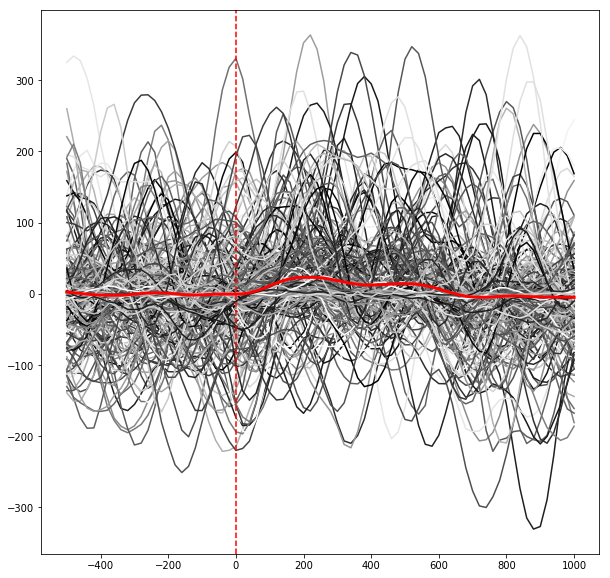

In [133]:
plt.figure(figsize=(10,10))
for behavior_chunk in behavior_chunks:
    plt.plot(x,behavior_chunk,color=str(np.random.uniform()))
#plt.
plt.plot(x,avg_trace,linewidth=3,color='r')
plt.axvline(0, color='r', linestyle='--')
#plt.ylim(0,np.max(avg_trace)*1.5)

In [284]:
unique_stimuli[0]['times'][-1]

1627359.8

In [306]:
np.diff(unique_stimuli[0]['times'])

array([ 21789. ,   6110. ,  15748.5,   9395.3,  19094.7,  12845.6,
         3059.4,  18912.2,   6588. ,  18929.6,   6257.6,  15844.1,
         9334.6,  18912.1,   6275.1,  19216.4,  16009.3, 186558. ,
        15470.4,  15705.2,  12776.1,   3111.4,  13106.5,  22136.7,
         3337.4,  19216.4,  15618.2,   3172.2,  22162.7,   6501.2,
        12967.3,  15844.1,   9777.7,  16174.5,   6144.8, 202628.1,
         3128.9,  15861.5,  12611. ,  15557.4,   9673.4,  19303.3,
         3024.5,  19277.3,  12515.3,   9560.5,   9429.9,  16070.2,
        12750.1,  18955.7,   9734.2,   9421.3,  13071.7, 195301.4,
         9386.5,  18842.7,  12393.7,   9664.7,   9464.8,  12741.4,
        15783.3,   6231.7,  15861.5,   9508.3,  15765.8,  12871.9,
        18912.2,  12515.3,  12880.6,   3128.7,  22258.5])

In [309]:
np.diff(unique_stimuli[0]['times']) - np.diff(master_times_test)

array([21.98158494,  6.13076764, 23.27757087,  1.54870681, 17.5222636 ,
       17.12907097, -2.88015725, 21.2420029 ,  8.23587834, 17.95092075,
        8.89319263, 15.42216015,  2.92195324, 21.1420029 ,  5.70211049,
       15.07577074, 15.093503  , 94.        , 14.16163873, 21.35973515,
        9.7023174 ,  7.73767846,  9.0450031 , 17.9331885 ,  6.13577488,
       15.07577074, 17.12406373,  6.46443203, 23.24210635,  4.20020691,
       14.68257811, 15.42216015, 11.50922822, 14.76484585, -0.45139665,
       18.83577488,  4.54659632, 12.13107801, 10.13097455, 18.39731016,
       10.66463894, 19.21144217,  3.60200703, 13.90252431, 17.88638527,
        1.22004966, 15.45762466, 13.92025657,  4.39339954, 23.35983861,
        9.39139251,  6.85762466, 15.62716739, 46.32385682, 13.43978895,
       13.81524933, 20.43287813,  1.96463894,  8.97546038, 16.38448169,
       16.69540658,  3.68427478, 12.13107801, 11.09329609, 19.88648872,
        2.04690668, 21.2420029 , 17.88638527, 10.74690668,  4.34

In [331]:
np.diff(unique_stimuli[0]['times']) - np.diff(durs_test)

array([21.98158494,  6.13076764, 23.27757087,  1.54870681, 17.5222636 ,
       17.12907097, -2.88015725, 21.2420029 ,  8.23587834, 17.95092075,
        8.89319263, 15.42216015,  2.92195324, 21.1420029 ,  5.70211049,
       15.07577074, 15.093503  , 94.        , 14.16163873, 21.35973515,
        9.7023174 ,  7.73767846,  9.0450031 , 17.9331885 ,  6.13577488,
       15.07577074, 17.12406373,  6.46443203, 23.24210635,  4.20020691,
       14.68257811, 15.42216015, 11.50922822, 14.76484585, -0.45139665,
       18.83577488,  4.54659632, 12.13107801, 10.13097455, 18.39731016,
       10.66463894, 19.21144217,  3.60200703, 13.90252431, 17.88638527,
        1.22004966, 15.45762466, 13.92025657,  4.39339954, 23.35983861,
        9.39139251,  6.85762466, 15.62716739, 46.32385682, 13.43978895,
       13.81524933, 20.43287813,  1.96463894,  8.97546038, 16.38448169,
       16.69540658,  3.68427478, 12.13107801, 11.09329609, 19.88648872,
        2.04690668, 21.2420029 , 17.88638527, 10.74690668,  4.34

In [311]:
1/115*1000

8.695652173913043

(150000, 400000)

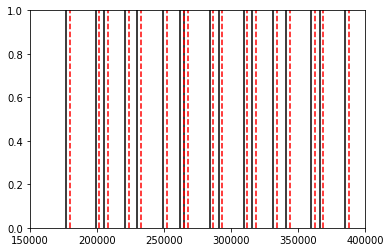

In [302]:
for time in unique_stimuli[0]['times']:
    plt.axvline(time,color='k')
    
for i in master_times_test:
    plt.axvline(i,color='r',linestyle='--')
    
plt.xlim(150000,400000)

In [330]:
np.diff(durs_test)

array([ 21767.01841506,   6103.86923236,  15725.22242913,   9393.75129319,
        19077.1777364 ,  12828.47092903,   3062.28015725,  18890.9579971 ,
         6579.76412166,  18911.64907925,   6248.70680737,  15828.67783985,
         9331.67804676,  18890.9579971 ,   6269.39788951,  19201.32422926,
        15994.206497  , 186464.        ,  15456.23836127,  15683.84026485,
        12766.3976826 ,   3103.66232154,  13097.4549969 ,  22118.7668115 ,
         3331.26422512,  19201.32422926,  15601.07593627,   3165.73556797,
        22139.45789365,   6496.99979309,  12952.61742189,  15828.67783985,
         9766.19077178,  16159.73515415,   6145.25139665, 202609.26422512,
         3124.35340368,  15849.36892199,  12600.86902545,  15539.00268984,
         9662.73536106,  19284.08855783,   3020.89799297,  19263.39747569,
        12497.41361473,   9559.27995034,   9414.44237534,  16056.27974343,
        12745.70660046,  18932.34016139,   9724.80860749,   9414.44237534,
        13056.07283261, 1

In [350]:
stimuli_master[11]

array([{'name': 'SineGrating', 'angle': 270, 'period': 20, 'rate': 20, 'color': 1},
       195310.7800537968], dtype=object)

In [320]:
len(master_times_test)

72

In [280]:
stimuli_master = np.load(os.path.join(vision_path, 'stimuli_master.npy'))

In [328]:
# lets get the times from stimuli_master when a unique stimulus was shown
master_times_test = []
durs_test = []
for i, stimulus in enumerate(stimuli_master):
    if stimulus[0]['name'] == 'SineGrating' and stimulus[0]['angle'] == 180:
        master_times_test.append(stimulus[1])
        durs_test.append(np.sum(durs[:i]))

(0, 400000)

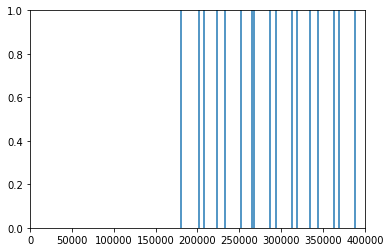

In [300]:
for i in master_times_test:
    plt.axvline(i)
    
plt.xlim(0,400000)

In [289]:
stimuli_master[-3][0]

{'angle': 180, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20}

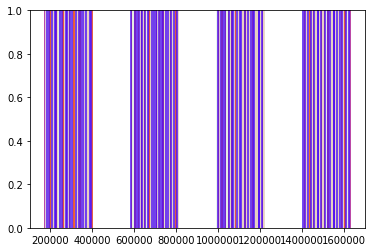

In [205]:
for stim in unique_stimuli:
    color = np.random.rand(1,3)[0]
    for time in stim['times']:
        plt.axvline(time,color=color)

In [204]:
color = np.random.rand(1,3)[0]
color

array([0.54998463, 0.04007302, 0.14436259])

In [194]:
unique_stimuli[1]

{'angle': 90,
 'color': 1,
 'name': 'SineGrating',
 'period': 20,
 'rate': 20,
 'times': [183175.9,
  195839.0,
  202009.8,
  214638.3,
  233567.8,
  239738.6,
  255669.6,
  268567.6,
  277971.5,
  296927.1,
  312771.2,
  319194.1,
  328693.7,
  344433.6,
  353881.0,
  376000.1,
  382127.6,
  398197.7,
  591056.8,
  600460.7,
  609899.5,
  622493.2,
  645047.0,
  654390.1,
  660830.4,
  676900.5,
  686513.0,
  702192.0,
  718157.9,
  724398.1,
  743718.9,
  759728.2,
  772469.5,
  785436.9,
  798256.5,
  807556.2,
  1000902.0,
  1016520.2,
  1019805.6,
  1038526.6,
  1047991.4,
  1064000.7,
  1070380.1,
  1086146.0,
  1095984.5,
  1118042.9,
  1130801.7,
  1137007.3,
  1152912.3,
  1168860.8,
  1178282.1,
  1184870.1,
  1207119.7,
  1219956.7,
  1412155.3,
  1424662.1,
  1434231.2,
  1440427.9,
  1452960.8,
  1465797.7,
  1484744.8,
  1494209.6,
  1506698.9,
  1525732.8,
  1538448.1,
  1547956.4,
  1564000.4,
  1573343.6,
  1585902.3,
  1598617.8,
  1611585.0,
  1621102.0]}

In [182]:
stimuli[0]

{'angle': 180, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20}

In [174]:
stimuli

[{'angle': 180, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 0, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 90, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 270, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 0, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 270, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 90, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 180, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 90, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 180, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 0, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 270, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 20},
 {'angle': 90, 'color': 1, 'name': 'SineGrating', 'period': 20, 'rate': 2

In [114]:
np.diff(pd_on_edges)

array([1.771702e+05, 1.740000e+01, 1.740000e+01, ..., 1.740000e+01,
       1.740000e+01, 1.740000e+01])

In [41]:
pd_on_edges

array([ 177170.2,  177187.6,  177205. , ..., 1628298.4, 1628315.8,
       1628333.2])

In [95]:
# get not grey stimuli
stimuli[0,0]['name']

'Grey'

In [ ]:
non_grey_stimuli = [stim for stim in stimuli if ]

In [96]:
non_grey_stimuli = [stim for i,stim in enumerate(stimuli) if stimuli[i,0]['name'] != 'Grey']

In [128]:
len(sine_stimuli)

288

(0, 1000)

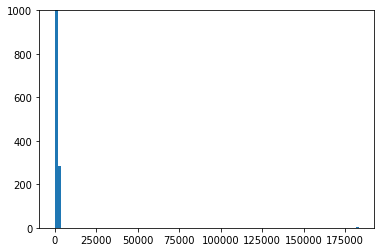

In [79]:
plt.hist(np.diff(pd_on_edges),bins=100);
#plt.xlim(10000,190000)
plt.ylim(0,1000)

In [54]:
1000/17.4*2

114.9425287356322

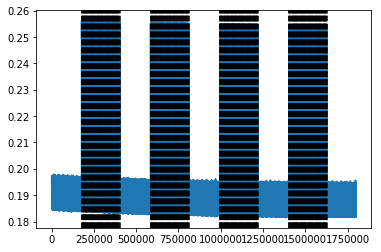

In [129]:
plt.plot(t,pd1)
for line in stimuli_starts:
    #print(line)
    plt.axvline(line,color='k',linestyle='--')
    
#plt.xlim(1628000,1628500)

(1628000, 1628500)

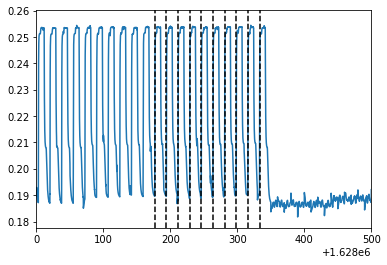

In [50]:
plt.plot(t,pd1)
for line in pd_on_edges[-10:]:
    #print(line)
    plt.axvline(line,color='k',linestyle='--')
    
plt.xlim(1628000,1628500)

(177000, 177500)

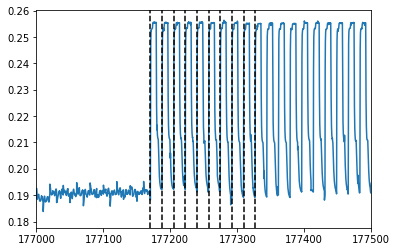

In [29]:
plt.plot(t,pd1)
for line in pd_on_edges[:10]:
    #print(line)
    plt.axvline(line,color='k',linestyle='--')
    
plt.xlim(177000,177500)

(177000, 177500)

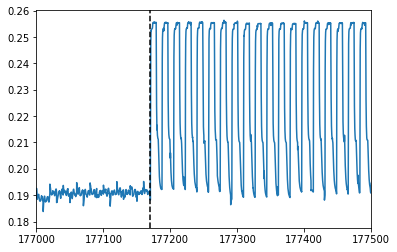

In [125]:
plt.plot(t,pd1)
for line in stimuli_starts[:10]:
    #print(line)
    plt.axvline(line,color='k',linestyle='--')
    
plt.xlim(177000,177500)

(177000, 190000)

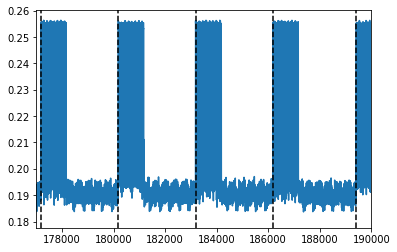

In [126]:
plt.plot(t,pd1)
for line in stimuli_starts[:10]:
    #print(line)
    plt.axvline(line,color='k',linestyle='--')
    
plt.xlim(177000,190000)

Text(0.5, 1.0, 'One stimuli block')

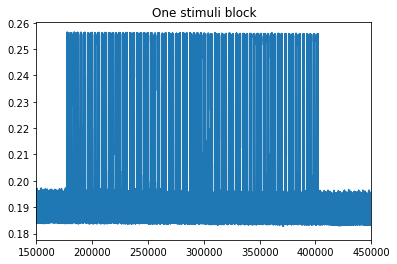

In [70]:
plt.plot(t,pd1)
plt.xlim(150000,450000)
plt.title('One stimuli block')

Text(0.5, 1.0, 'One stimulus')

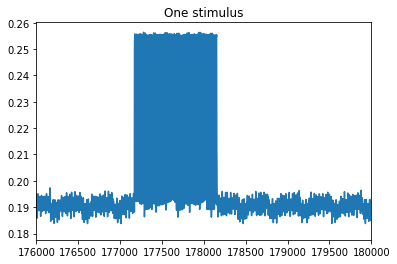

In [75]:
plt.plot(t,pd1)
plt.xlim(176000,180000)
plt.title('One stimulus')

Text(0.5, 1.0, 'One stimulus (individual frame peaks)')

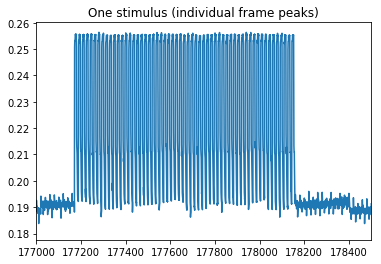

In [78]:
plt.plot(t,pd1)
plt.xlim(177000,178500)
plt.title('One stimulus (individual frame peaks)')

In [ ]:
d1_thresh = np.where(self.d_1>threshold)[0]
on_flash = d1_thresh[np.where(np.diff(d1_thresh)>50)[0]] # where a high period starts, distance between on/off in sampling rate
self.darkflash_1 = self.t[on_flash]
d1_thresh = np.where(self.d_1<threshold)[0]
on_flash = d1_thresh[np.where(np.diff(d1_thresh)>50)[0]] # where a high period starts, distance between on/off in sampling rate
self.lightflash_1 = self.t[on_flash]